# Modeling the Universe: pset7

In [1]:
import math
import numpy as np
import kplr

# Find the target KOI.
client = kplr.API()
koi = client.koi(97.01)

# Get a list of light curve datasets.
lcs = koi.get_light_curves(short_cadence=False)

# Open the first dataset and read it
f = lcs[0].open()
hdu_data = f[1].data
f.close()

In [2]:
import scipy
from scipy.integrate import quad
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

Next, import my_transit helper function and define func1 and func2, which are the two functions to be integrated to compute the flux theory curve (which is the ratio of the integral(func1)/integral(func2)).

In [3]:
import my_transit

def I(r):
    '''A Limb-darkening function'''
    mu = (1 - (r**2))**(0.5)
    return 1 - (1 - (mu**(0.5)))

def func1(r, p, z):
    return I(r) * (1 - my_transit.delta(p,r,abs(z))) * 2 * r

def func2(r, p, z):
    return I(r) * 2 * r

In [4]:
time = np.asarray(hdu_data["time"])  # get the time of each observation in UTC 
flux = np.asarray(hdu_data["sap_flux"]) # get the flux in counts/ sec
flux_err = np.asarray(hdu_data["sap_flux_err"]) # get the error in the flux

## Problem 1:

In [5]:
# extracting data in time range (124 < t < 125)
p1_time_idx = ((time > 124) & (time < 125))
time_p1 = time[p1_time_idx]
flux_p1 = flux[p1_time_idx]
flux_err_p1 = flux_err[p1_time_idx]

In [6]:
# flux true mean & std finding 
def two_sigma_mean_std_calculation(f, iterations=5):
    """ recursively calculates the mean and std of an array by doing 2 sigma cutoffs
    for a number of iterations
    """
    f_bar = np.mean(f)
    f_sig = np.std(f)
    if iterations == 0:
        return f_bar, f_sig
    else:
        idx = np.where(np.abs(f - f_bar) / f_sig < 2)
        return two_sigma_mean_std_calculation(f[idx], iterations=iterations-1)

In [7]:
f_bar, f_sig = two_sigma_mean_std_calculation(flux_p1)

In [8]:
# flux normalization
f_norm = flux_p1 / f_bar
f_err_norm = flux_err_p1 / f_bar

In [9]:
p = 0.0775
tau = 0.1
t_0 = 124.51

def get_z(t, t_0=124.51, tau=0.1):
    """ calculate z from t"""
    return (t - t_0) / tau

In [10]:
def f_model_p1(t, t_0, tau, p):
    """ gets model f given a time stamp and a p
    calculates z from p and integrates the provided func1 and func2
    """
    z = get_z(t, t_0=t_0, tau=tau)
    num, num_err = quad(lambda x: func1(x, p, z), 0, 1)
    denum, denum_err = quad(lambda x: func2(x, p, z), 0, 1)
    return num / denum

In [11]:
# calcualte the model_flux
f_model = np.asarray([f_model_p1(t, t_0, tau, p) for t in time_p1])

In [12]:
# chi2 = sum of ((data - model) / data uncertainty) ** 2
chi_2_p1 = np.sum(((f_norm - f_model) / f_err_norm) ** 2)

In [13]:
print('The Chi squared assuming p = {0} is {1}'.format(p, chi_2_p1))

The Chi squared assuming p = 0.0775 is 465.1986924205623


## Problem 2:

In [83]:
matplotlib.rcParams['font.family'] = ['serif']
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams.update({'font.size': 12})

/Users/larryli/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


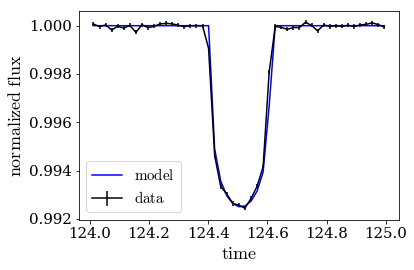

In [77]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.errorbar(time_p1, f_norm, f_err_norm, color='black', label=r'$\mathrm{data}$')
ax.plot(time_p1, f_model, color='blue', label=r'$\mathrm{model}$')

ax.legend(fontsize=15)
ax.set_xlabel(r'$\mathrm{time}$', fontsize=18)
ax.set_ylabel(r'$\mathrm{normalized\ flux}$', fontsize=18)
fig.tight_layout()
fig.show()

#### Looks like a pretty good fit to my eyes!

In [16]:
d_o_f = f_model.shape[0] - 3
print('degrees of freedom: {0}'.format(d_o_f))

degrees of freedom: 46


### To get the p-value we use $\Gamma(\frac{\nu}{2}, \frac{\chi^2}{2})$

In [17]:
scipy.special.gammaincc(d_o_f / 2, chi_2_p1 / 2)

1.098869070516888e-70

#### this is extrememly unlikely!!!

## Problem 3:

In [18]:
def flux_model(ts, t_0, tau, p):
    """ calculate model fluxs based on given ts, t_0, tau, and p
    """
    def flux_calc(p, z):
        """ calculate the model flux at a given (p, z) """
        num, num_err = quad(lambda x: func1(x, p, z), 0, 1)
        denum, denum_err = quad(lambda x: func2(x, p, z), 0, 1)
        return (num / denum)
    zs = get_z(ts, t_0=t_0, tau=tau)
    fs = np.zeros_like(ts)
    for i in range(fs.shape[0]):
        fs[i] = flux_calc(p, zs[i])
    return fs

def chi_2(data, data_err, model):
    """ calculate the chi2
    """
    return np.sum(((data - model) / data_err) ** 2)

In [19]:
taus = np.linspace(0.08, 0.13, 60)
p_2 = 0.0775
t_0_2 = 124.51

In [20]:
# chi2 values for 30 taus from 0.08 to 0.13
chi_2s = [chi_2(f_norm, f_err_norm, flux_model(time_p1, t_0_2, tau, p_2)) for tau in taus]

In [21]:
best_fit_tau = taus[np.argmin(chi_2s)]

In [22]:
print('Best fitting model has tau = {0} and chi2 = {1}'.format(best_fit_tau, np.min(chi_2s)))

Best fitting model has tau = 0.09694915254237288 and chi2 = 247.24014256441896


/Users/larryli/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


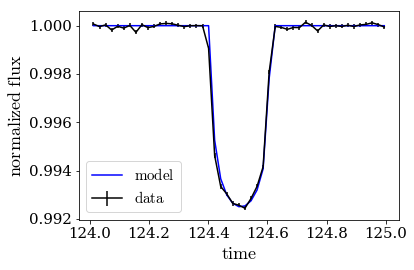

In [78]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.errorbar(time_p1, f_norm, f_err_norm, color='black', label=r'$\mathrm{data}$')
ax.plot(time_p1, flux_model(time_p1, t_0_2, best_fit_tau, p_2), color='blue', label=r'$\mathrm{model}$')

ax.legend(fontsize=15)
ax.set_xlabel(r'$\mathrm{time}$', fontsize=18)
ax.set_ylabel(r'$\mathrm{normalized\ flux}$', fontsize=18)
fig.tight_layout()
fig.show()

In [24]:
print('The p-value for this model is {0}'
      .format(scipy.special.gammaincc(d_o_f / 2, np.min(chi_2s) / 2)))

The p-value for this model is 2.3544142978656128e-29


#### This is better than last time but still very very unlikely

/Users/larryli/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


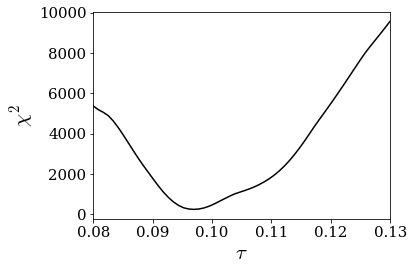

In [79]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(taus, chi_2s, color='black')

ax.set_xlim(0.08, 0.13)
ax.set_xlabel(r'$\tau$', fontsize=21)
ax.set_ylabel(r'$\chi^2$', fontsize=21)
fig.tight_layout()
fig.show()

### From the slides we have, for M = 1: $\Delta \chi^2 = 1 \rightarrow 68.3 \% (1 \sigma)$. So from the above plot but zoomed in around the minimum we estimate the uncertainty in $\tau$

/Users/larryli/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


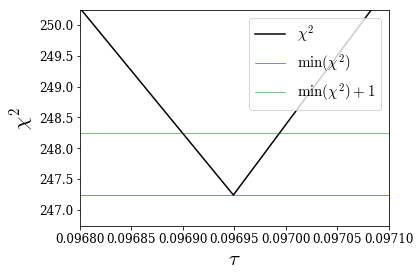

In [94]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(taus, chi_2s, color='black', label=r'$\chi^2$')

ax.plot([0,1], [np.min(chi_2s), np.min(chi_2s)], color='blue', linewidth=0.5,
        label=r'$\mathrm{min}(\chi^2)$')
ax.plot([0,1], [np.min(chi_2s)+1, np.min(chi_2s)+1], color='green', linewidth=0.5, 
        label=r'$\mathrm{min}(\chi^2) + 1$')

ax.legend(fontsize=15)
ax.set_xlim(0.0968, 0.0971)
ax.set_ylim(np.min(chi_2s)-.5, np.min(chi_2s)+3)
ax.set_xlabel(r'$\tau$', fontsize=21)
ax.set_ylabel(r'$\chi^2$', fontsize=21)
fig.tight_layout()
fig.show()

### from the $\chi^2$ plot, the $1 \sigma$ uncertainty in $\tau$ is $\approx 0.00005$

## Problem 4:

In [27]:
import emcee

We assume gaussian errors, so

$$P(\mathrm{data}\ |\ \mathrm{model}) = \prod_i^N \frac{1}{\sqrt{2\pi\sigma_i^2}} \exp(-\frac{(y_i - y(x_i))^2}{2\sigma_i^2})$$

and
$$\mathcal{L} = \ln(P(d\ |\ m)) = -\frac{N \ln(2\pi)}{2} - \sum_i^N \ln(\sigma_i) - \sum_i^N \frac{(y_i - y(x_i))^2}{2 \sigma_i^2}$$

as for the priors, we (I) don't have much previous knowledge about planet transits, but we do know that $\tau$ should be strictly positive and less than half of the duraion of our dataset, 

$$p(\tau) \propto \begin{cases}
1\ =& 0 < \tau < 0.5\\
0\ =& \mathrm{otherwise}
\end{cases} $$

we also know that $t_0$ should fall somewhere in the duration of our dataset,
$$p(t_0) \propto \begin{cases}
1\ =& 124 < t_0 < 125\\
0\ =& \mathrm{otherwise}
\end{cases}$$

and that $p$ should be between 0 (no transit) and some fraction of the star's lightcurve,
$$p(p) \propto \begin{cases}
1\ =& 0 < p < 0.1\\ 
0\ =& \mathrm{otherwise}
\end{cases}$$

In [28]:
def lglike(theta, x, y, y_err):
    """ log likelihood function from above definition"""
    p, tau, t_0 = theta  # unpacking the parameters
    y_model = flux_model(x, t_0, tau, p)
    
    N = len(x)
    part_1 = N * np.log(2 * np.pi) / 2
    part_2 = np.sum(np.log(y_err))
    part_3 = np.sum((y - y_model) ** 2 / (2 * y_err ** 2))
    return - part_1 - part_2 - part_3

def lgprior(theta):
    """ log prior, b/c uniform priors this is basically just a restriction on the parameter space """
    p, tau, t_0 = theta  # unpacking parameters
    if p <= 0 or p >= 0.1:
        return -np.inf
    elif tau <= 0 or tau >= 0.5:
        return -np.inf
    elif t_0 <= 124 or t_0 >= 125:
        return -np.inf
    else:
        return 0

def lgpost(theta, x, y, y_err):
    """ log posterior, log prior + log likelihood, here it's -inf if the parameters
    are outside ofthe uniform prior bounds"""
    prior = lgprior(theta)
    if np.isfinite(prior):
        return lglike(theta, x, y, y_err)
    else:
        return prior

In [29]:
n_dim = 3  # t_0, tau, & p
n_walkers = 10

In [30]:
# initialize the MCMC sampler
sampler = emcee.EnsembleSampler(n_walkers, n_dim, lgpost, args=(time_p1, f_norm, f_err_norm))

In [31]:
# starting positions of the walkers, initialized to be around the parameters given in part1
p_1_theta = [0.0775, 0.1, 124.51]  # p, tau, t_0
pos = p_1_theta + 1e-3 * np.random.randn(n_walkers, n_dim)

In [32]:
n_steps = 1000
_ = sampler.run_mcmc(pos, n_steps)

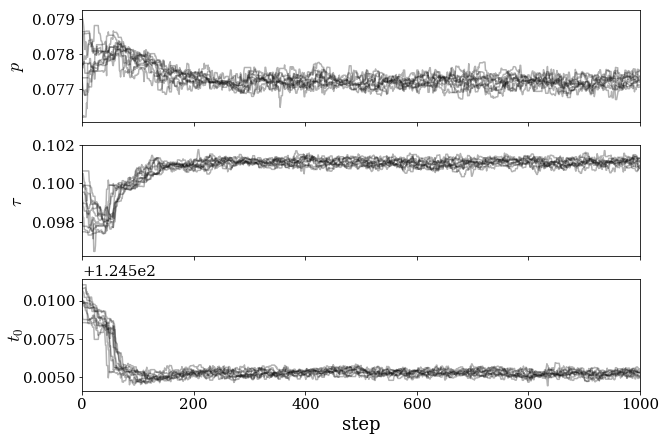

In [81]:
# looking at the mcmc chain in individual parameters
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = [r'$p$', r'$\tau$', r'$t_0$']
for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i].T, "k", alpha=0.3)
    ax.set_xlim(0, n_steps)
    ax.set_ylabel(labels[i], fontsize=18)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel('step', fontsize=18);

### ues only after step 200 (post burnin)

In [44]:
flat_samples = samples[:, 200:, :]
flat_samples = np.reshape(flat_samples, (8000, 3))

In [51]:
import corner

/Users/larryli/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


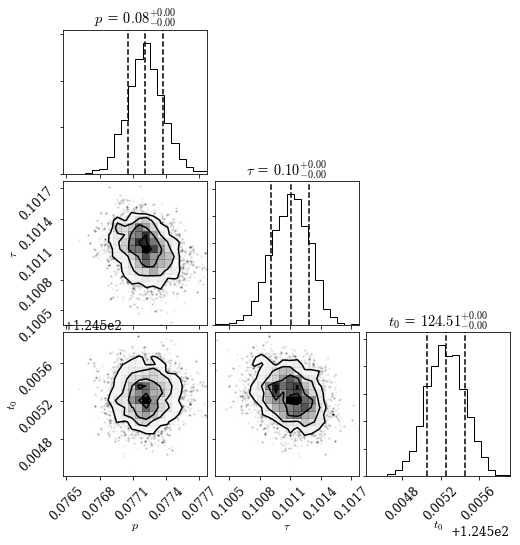

In [84]:
fig = corner.corner(flat_samples, labels=labels,
                    quantiles = [0.159, .5, 0.841],
                    show_titles = True)
fig.show()

In [62]:
p_best, tau_best, t0_best = np.mean(flat_samples, axis=0)
chi2_best = chi_2(f_norm, f_err_norm, flux_model(time_p1, t0_best, tau_best, p_best))

In [89]:
print('Best fitting params: p = {0:0.5f}, tau = {1:0.5f}, t_0 = {2:0.5f}'
      .format(p_best, tau_best, t0_best))
print('Best fitting chi2 = {0:0.5f}, with p value of {1:0.5f}'
      .format(chi2_best, scipy.special.gammaincc(d_o_f / 2, chi2_best / 2)))

Best fitting params: p = 0.07721, tau = 0.10110, t_0 = 124.50526
Best fitting chi2 = 53.31714, with p value of 0.21345


In [90]:
print('The 1 sigma uncertainty values are:')
print('sigma(p) = {0:0.6f}\nsigma(tau) = {1:0.6f}\nsigma(t0) = {2:0.6f}'.format(*np.std(flat_samples, axis=0)))

The 1 sigma uncertainty values are:
sigma(p) = 0.000162
sigma(tau) = 0.000187
sigma(t0) = 0.000196


#### Note the 1-sigma value for tau is around 4 times bigger than the one we estimated from the $\chi^2$ plot